<a href="https://colab.research.google.com/github/TiphaineV/gpeg/blob/heavy/Graph_heavy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading Files

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.feature_selection import chi2
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
import scipy.sparse as sparse
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

##### 10M

Lien pour télécharger le dataset : 
https://drive.google.com/file/d/1W6nc4VMMD6VDpm96ydbDNSRf5N3K-cns/view?usp=sharing

Lien pour télécharger la matrice d'adjacence :
https://drive.google.com/file/d/1kJi8xD5n9bbIyDcla58CjB3qLDBF9DwB/view?usp=sharing

In [ ]:
userMovieFile_10M_id = '1W6nc4VMMD6VDpm96ydbDNSRf5N3K-cns'
adjency_10M_id = '1kJi8xD5n9bbIyDcla58CjB3qLDBF9DwB'

In [ ]:
# -- Loading userMovieData 10M
downloaded = drive.CreateFile({'id':userMovieFile_10M_id}) 
downloaded.GetContentFile('userMovieData.csv')

In [ ]:
# -- Loading adjency 
downloaded = drive.CreateFile({'id':adjency_10M_id}) 
downloaded.GetContentFile('adjency-10M.npz')

In [ ]:
# -- loading Data
userMovieData = pd.read_csv('userMovieData.csv', encoding='utf-8', compression='gzip')

## Modules

### Graph

In [ ]:
#%% Modules
#standard
from abc import ABC, abstractmethod
import time
import numpy as np
import numpy.random as rd
import scipy.sparse as sparse
import pandas as pd



#%% Graph class
class Graph:
    def __init__(self, userData = None, nChunk= np.inf, chunksize= int(1e6), path= None):
        '''
        Parameters
        --------
        size: str
            'small' (100K), 'heavy' (20M)
        '''
        # -- IO
        print('Graph init ...')
        if path != None:
            self.load_adjency(path)
        # -- Attributes
        if path == None:
            self.set_adjency(userData, nChunk= nChunk, chunksize= chunksize)

        self.rowFormat = sparse.csr_matrix(self.adjency)
        self.colFormat = sparse.csc_matrix(self.adjency)
        pass

    def get_user(self, userId: int):
        return self.rowFormat[userId]

    def get_movie(self, movieId: int):
        return self.colFormat[:,movieId]

    def load_adjency(self, path):
        try:
            self.adjency = sparse.load_npz(path)
            self.edges = self.adjency.data

        except FileNotFoundError:
            print("file was not found, please try again or provide userData")
            raise
        pass

    def save_adjency(self, fileName):
        sparse.save_npz(fileName, self.adjency)
        pass


    def set_adjency(self, userData, nChunk= np.inf, chunksize= int(1e6)):
        # -- Builds the matrix
        rows = []
        cols = []
        data = []
        for k,chunk in enumerate(userData):
            print('Processing chunk {}.'.format(k))
            for idx in range(len(chunk)):
                # -- keys : userId, movieId.
                row = chunk.iloc[idx]
                # -- getting ids
                userId, movieId= row['userId'], row['movieId']

                # -- updating rows, cols, data
                rows.append(userId)
                cols.append(movieId)
                data.append(k*chunksize+idx)

            #### temp ####
            if k == nChunk - 1:
                break

        adjency = sparse.coo_matrix((data, (rows, cols)), shape=(int(max(rows))+1, int(max(cols))+1))

        self.adjency = adjency
        self.edges = adjency.data
        pass

    def train_test_split(self, alpha: float):
        # -- Checking parameter alpha
        if alpha >= 1 or alpha <=0 or not(isinstance(alpha,float)):
            raise ValueError('alpha must be a float in ]0,1[')

        # -- Parameters
        edges = self.edges
        n = len(edges)
        nTest = int(alpha * n)
        indexes = list(range(n))

        # -- Randomizing data
        rd.shuffle(indexes)

        # -- Getting the split
        idxTrain, idxTest = sorted(indexes[nTest:]), sorted(indexes[:nTest])
        nTrain, nTest = len(idxTrain), len(idxTest)

        return edges[idxTrain], edges[idxTest]
    
    def cv_split(self, cv=5, RANDOM_SEED=None):
        rd.seed(seed=RANDOM_SEED)
        
        edges = self.edges.copy()
        n_f = len(edges)//cv

        # -- Randomizing data
        rd.shuffle(edges)

        return np.array([edges[k*n_f:(k+1)*n_f] if k<(cv-1) else edges[k*n_f:] for k in range(cv)])    

### Features

In [ ]:
class NodeFeatures:
    '''See https://pandas.pydata.org/pandas-docs/stable/reference/groupby.html
    '''  
    Genres = ['Action', 'Adventure', 'Animation', 
        "Children", 'Comedy', 'Crime', 'Documentary', 'Drama',
        'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery',
        'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', '(no genres listed)']
    
    mn = 1891 # small = 1900, heavy = 1891
    mx = 2015 # keep this one
    Years = ["{0} - {1}".format(i, i + 9) for i in range(mn, mx, 10)] #caution

    # -- user
    @staticmethod
    def agg_user(df):
      '''returns dfByUser
      '''
      return df.groupby('userId')

    @staticmethod 
    def user_mean(df):
        return NodeFeatures.agg_user(df)['rating'].agg(np.mean)
    
    @staticmethod
    def user_std(df):
        return NodeFeatures.agg_user(df)['rating'].std(ddof=0)
    
    @staticmethod
    def user_degree(df):
        return NodeFeatures.agg_user(df).size()
      
    @staticmethod 
    def user_corr_movie(df):
        # has no interest, but feasible
        return dfByUser[['userId', 'movieId']].corr()['userId'][:, 'movieId']
    
    @staticmethod
    def user_tag(df):
        return NodeFeatures.agg_user(df)['tag'].count().fillna(value=0).astype('uint32')
      
    @classmethod
    def user_genre(cls, df, top=3):
        '''df must have a label
        '''
        cols = ['userId','label'] + cls.Genres
        new_index = df.userId.drop_duplicates().sort_values()
        df_ = df[cols].loc[df['label']==1].groupby('userId').sum().reindex(new_index, fill_value=0).drop(columns='label')
        v_ = df_.values
        return pd.DataFrame(data = np.argsort(v_, axis=1) > (v_.shape[1] - 1) - top, columns = df_.columns, index= df_.index)
    
    @classmethod
    def user_year(cls, df, top=3):
        '''df must have a label
        '''
        cols = ['userId','label'] + cls.Years
        new_index = df.userId.drop_duplicates().sort_values()
        df_ = df[cols].loc[df['label']==1].groupby('userId').sum().reindex(new_index, fill_value=0).drop(columns='label')
        v_ = df_.values
        return pd.DataFrame(data = np.argsort(v_, axis=1) > (v_.shape[1] - 1) - top, columns = df_.columns, index= df_.index)
    
    # -- movie

    @staticmethod 
    def movie_mean(dfByMovie:pd.DataFrame):
        return dfByMovie['rating'].agg(np.mean)
    
    @staticmethod
    def movie_std(dfByMovie: pd.DataFrame):
        return dfByMovie['rating'].std(ddof=0)
    
    @staticmethod
    def movie_degree(dfByMovie: pd.DataFrame):
        return dfByMovie.size()
    
    @staticmethod
    def movie_tag(dfByMovie: pd.DataFrame):
        return dfByMovie['tag'].count().fillna(value=0).astype('uint32')

    @classmethod
    def movie_genre(cls, dfByMovie: pd.DataFrame):
        return dfByMovie[cls.Genres].first()
    
    @classmethod
    def movie_year(cls, dfByMovie: pd.DataFrame):
        return dfByMovie[cls.Years].first()
    
    
    # -- graph

    @staticmethod
    def f():
      pass
    


### RecSystem

In [ ]:
'''
Recommender systems abstract classes.
'''
#%% Modules
#standard
from abc import ABC, abstractmethod
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

#%% Trivial Recommandation System
class _RecSystem(ABC):
    '''
    Abstract class for recommender systems.
    '''
    def __init__(self):
        pass

    @abstractmethod
    def fit(self, edges):
        pass

    @abstractmethod
    def predict(self, edges, *args):
        pass
    pass



class _Clf(_RecSystem):
    '''
    Classifier recommendation system
    '''
    def __init__(self, df, adj, likeThr, RANDOM_SEED= None):
        super().__init__()
        self.df = df
        self.adj = adj
        self.likeThr = likeThr
        self.scaler = None
        self.RANDOM_SEED = None

        self.df['label'] = self._get_labels(adj.data)
        pass
    
    def reset(self):
        self.scaler= None
        self.xTrain= None
        self.X_u = None
        self.X_m = None
        self.yTrain = None

    def _get_feature_matrix(self, edges):
        df = self.df.iloc[edges]
        featFncts = self.featFncts

        dfByMovie = df.groupby('movieId')

        X = pd.DataFrame() 
        X['userId'] = df['userId']
        X['movieId'] = df['movieId']
        X_u = pd.DataFrame(index= df['userId'].drop_duplicates().sort_values())
        X_m = pd.DataFrame(index= df['movieId'].drop_duplicates().sort_values())

        k = 0
        for featFnct in featFncts['user']:
            dfU= featFnct(df)
            if isinstance(dfU, pd.Series):
              X_u['xu'+str(k)] = dfU
              k+=1
            
            if isinstance(dfU, pd.DataFrame):
              # comes from ohe
              colU = dfU.columns
              for col in colU:
                X_u['xu'+str(k)] = dfU[col]
                k += 1
        k = 0
        for featFnct in featFncts['movie']:
            dfM= featFnct(dfByMovie)
            if isinstance(dfM, pd.Series):
              X_m['xm'+str(k)] = dfM
              k+=1
            
            if isinstance(dfM, pd.DataFrame):
              # comes from ohe
              colM = dfM.columns
              for col in colM:
                X_m['xm'+str(k)] = dfM[col]
                k += 1
        
        xTrain = X.merge(X_u, on='userId', how='left').merge(X_m, on='movieId', how='left')
        xTrain.index = df.index
        return xTrain, X_u, X_m

    def _get_labels(self, edges):
        return (self.df['rating'].iloc[edges] > self.likeThr).astype('uint8')

    def _get_known_edges(self, edges):
        ''' gets the edges for which we have data for both the user and the movie
        '''
        X_u = self.X_u
        X_m = self.X_m
        xTrain = self.xTrain
        d = np.column_stack((self.adj.row, self.adj.col))[edges]
        data = np.zeros((d.shape[0],), dtype=bool)

        unicU, invU  = np.unique(self.adj.row[edges], return_inverse=True)
        _, _, commU = np.intersect1d(self.xTrain['userId'], unicU, assume_unique=False, return_indices=True)
        maskU = np.zeros_like(unicU, dtype= bool)
        maskU[commU] = True
        knownEdgeUser = np.where(maskU[invU])

        unicM, invM  = np.unique(self.adj.col[edges], return_inverse=True)
        _, _, commM = np.intersect1d(self.xTrain['movieId'], unicM, assume_unique=False, return_indices=True)
        maskM = np.zeros_like(unicM, dtype= bool)
        maskM[commM] = True
        knownEdgeMovie = np.where(maskM[invM])
        
        # index in xTrain
        knownE = edges[np.intersect1d(knownEdgeUser, knownEdgeMovie, assume_unique=True)]

        knownU = self.adj.row[knownE]
        knownM = self.adj.col[knownE]

        # -- getting data on user
        unicU = np.unique(knownU)
        _,commX_u, _ = np.intersect1d(X_u.index, unicU, assume_unique=True, return_indices=True)
        X_uT = X_u.iloc[commX_u] 

        # -- getting data on movies
        unicM = np.unique(knownM)
        _,commX_m, _ = np.intersect1d(X_m.index, unicM, assume_unique=True, return_indices=True)
        X_mT = X_m.iloc[commX_m]

        # -- Building the matrix
        X = pd.DataFrame({'userId': knownU, 'movieId': knownM})
        xTestKnown = X.merge(X_uT, on='userId', how='left').merge(X_mT, on='movieId', how='left')
        xTestKnown.index = knownE
        unknownE = np.setdiff1d(edges, knownE, assume_unique=True)
        yTestUnknown = pd.Series(np.random.randint(2, size= len(unknownE)), index= unknownE)

        return xTestKnown, yTestUnknown
    
    def _set_scaler(self, X):
        scaler = StandardScaler()
        scaler.fit(X)
        self.scaler = scaler
        pass

    def _preprocess(self, X):
        '''scaling applied to both xTrain and xTest.
        '''
        nonBoolCols = X.columns.difference(X.columns[X.dtypes.values == 'bool']).drop(['userId','movieId'])
        if self.scaler is None:
          self._set_scaler(X[nonBoolCols])
        assert X[nonBoolCols].iloc[:,0].mean() > 1e-13
        mean_ = self.scaler.mean_
        scale_ = self.scaler.scale_
        X[nonBoolCols] -= mean_
        try:
          X[nonBoolCols] *= 1/ (scale_ + 1e-2)
        except ZeroDivisionError:
          print('Constant columns in the DS')
          raise
        return X.drop(columns= ['userId', 'movieId'])
    
    def _get_sparse(self, X, dType):
        '''get preprocessed data as a sparse matrix for the classifier
        '''
        if dType == 'csr':
          return X.astype(pd.SparseDtype('float32', 0.)).sparse.to_coo().tocsc()
        elif dType == 'csc':
          return X.astype(pd.SparseDtype('float32', 0.)).sparse.to_coo().tocsc()
        elif dType == 'coo':
          return X.astype(pd.SparseDtype('float32', 0.)).sparse.to_coo()
        elif dType == None:
          print('Warning: Dense matrix provided to classifier')
          return X
        else:
          raise ValueError('Provide a sparse matrix type or None')
    
    def fit(self, edges, dType='csr'):
        self.xTrain, self.X_u, self.X_m = self._get_feature_matrix(edges)
        self.yTrain = self._get_labels(edges)
        self.clf.fit(self._get_sparse(self._preprocess(self.xTrain), dType= dType), self.yTrain)
        pass

    def _predict_known(self, xTestKnown, dType):
        return pd.Series(self.clf.predict(self._get_sparse(self._preprocess(xTestKnown), dType)),
                                          index= xTestKnown.index)


    def predict(self, edges, dType='csr'):
        xTestKnown, yTestUnknown = self._get_known_edges(edges)

        # -- prediction
        yTestKnown = self._predict_known(xTestKnown, dType)

        # -- check if it is a partition
        assert len(set(yTestKnown.index).intersection(yTestUnknown.index)) ==0
        assert len(set(yTestKnown.index).union(yTestUnknown.index)) == len(edges)
        yPred = pd.Series(np.zeros_like(edges, dtype='uint8'), index=edges)
        yPred[yTestKnown.index] = yTestKnown.astype('uint8')
        yPred[yTestUnknown.index] = yTestUnknown.astype('uint8')
        return yPred
    pass

### CrossValidation

In [ ]:
class KFold:
  def __init__(self, edges, cv=5, RANDOM_SEED=None):
    self.edges = edges
    self.cv = cv
    self.RANDOM_SEED = RANDOM_SEED
  
  def get_split(self):
      rd.seed(seed=self.RANDOM_SEED)
      
      edges = self.edges
      n_f = len(edges)//cv

      # -- Randomizing data
      rd.shuffle(edges)

      return np.array([edges[k*n_f:(k+1)*n_f] if k<(cv-1) else edges[k*n_f:] for k in range(cv)])    

class StratifiedKFold(KFold):
  def __init__(self, edges, y, cv=5, RANDOM_SEED=None):
    super().__init__(edges, cv, RANDOM_SEED)
    self.y = y
  
  def get_split(self):
    edges = self.edges
    y = self.y
    rd.seed(seed=self.RANDOM_SEED)
    
    rd.shuffle(edges)
    pos = np.array_split(edges[y==1], self.cv)
    neg = np.array_split(edges[y==0], self.cv)

    return np.array([np.concatenate((pos[k], neg[k])) for k in range(self.cv)])

In [ ]:
def cross_val_score(clf: _Clf, cv=5, RANDOM_SEED=None):
  edges = graph.edges.copy()
  y = np.array(clf._get_labels(edges))
  skf = StratifiedKFold(edges, y, cv, RANDOM_SEED)
  folds = skf.get_split()
  scores = []

  for k in range(cv):
    idx_folds = list(range(cv))
    idx_folds.pop(k)
    edges = np.concatenate(folds[idx_folds])
    clf.fit(edges)
    yPred = clf.predict(folds[k])
    yTrue = clf._get_labels(folds[k])
    scores.append(f1_score(yTrue, yPred, average='macro'))
    clf.reset()
  
  return scores

## Graph construction

##### 10M

In [ ]:
# -- Graph construction, nChunk * 1e6 rows are processed from movieLens 25M.
# -- Takes around 2'30 for one chunk
graph = Graph(path = 'adjency-10M.npz')
#userMovieDatabyChunk = pd.read_csv('userMovieData.csv', chunksize= int(1e6), encoding='utf-8', compression='gzip')
#graph = Graph(userMovieDatabyChunk)

Graph init ...


In [ ]:
#graph.save_adjency('adjency-10M-v2.npz')

## Exploratory Data Analysis

### Degree Distribution

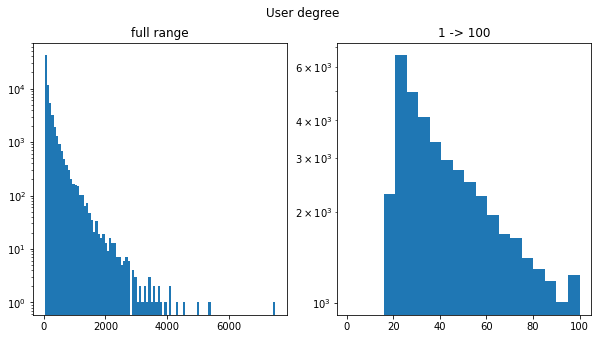

In [ ]:
n = graph.rowFormat.shape[0]
degreeDist = [graph.rowFormat[i].nnz for i in range(1,n)]

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
fig.suptitle('User degree')
ax1.hist(degreeDist, bins= 100, log=True)
ax1.set_title('full range')
ax2.hist(degreeDist, bins = 20, range=(0,100), log=True)
ax2.set_title('1 -> 100')
plt.show()

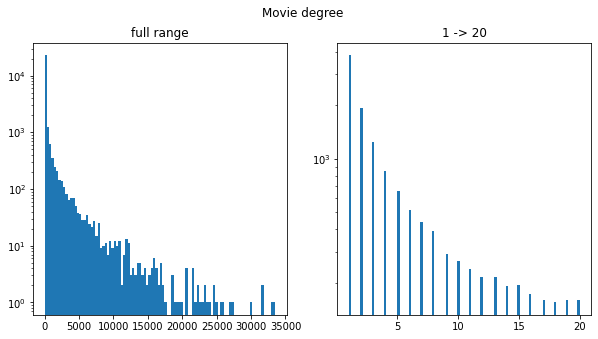

In [ ]:
m = graph.colFormat.shape[1]
degreeDist = [graph.colFormat[:,i].nnz for i in range(1,m)]

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
fig.suptitle('Movie degree')
ax1.hist(degreeDist, bins= 100, log=True)
ax1.set_title('full range')
ax2.hist(degreeDist, bins = 100, range=(1,20), log= True)
ax2.set_title('1 -> 20')
plt.show()

weight of the first degrees 0.6928344338469064


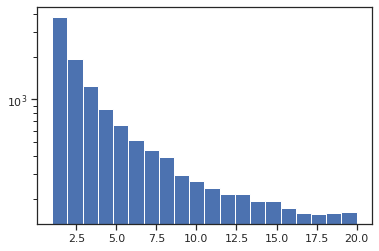

In [ ]:
count = plt.hist(degreeDist, bins = 20, range=(1,20), log= True)[0]

print('weight of the first degrees', np.sum(count[[0,1,2,3,4]]) /np.sum(count))

### rating distribution

In [ ]:
userMovieData.columns

Index(['userId', 'movieId', 'rating', 'tag', '1891 - 1900', '1901 - 1910',
       '1911 - 1920', '1921 - 1930', '1931 - 1940', '1941 - 1950',
       '1951 - 1960', '1961 - 1970', '1971 - 1980', '1981 - 1990',
       '1991 - 2000', '2001 - 2010', '2011 - 2020', 'Action', 'Adventure',
       'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery',
       'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', '(no genres listed)',
       'label'],
      dtype='object')

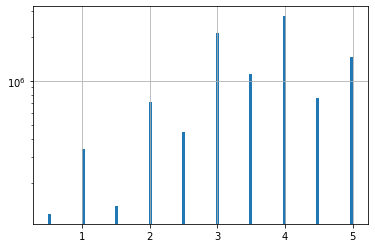

In [ ]:
userMovieData['rating'].hist(bins= 100,log=True)

tags

In [ ]:
userMovieData['tag'][userMovieData['tag'].notna()].apply(lambda x: x[1:-1].split(','))

7453                                         ['New Zealand']
7461                                 ['surreal',  'unusual']
7466       ['cute',  'emotional',  'girls who play boys',...
10859      ['animation',  'beautiful',  'characters',  'D...
14467      ['dark comedy',  'drugs',  'Nudity (Full Front...
                                 ...                        
9988160                                 ['comedy',  'funny']
9988188                                             ['boat']
9988361                                   ['comedy',  'God']
9988696    ['Hailee Steinfeld',  'Jeff Bridges',  'predic...
9995750                      ['sequel better than original']
Name: tag, Length: 63417, dtype: object

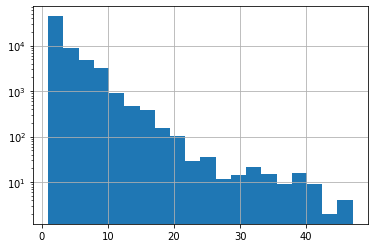

In [ ]:
userMovieData['tag'][userMovieData['tag'].notna()].apply(lambda x: x[1:-1].split(',')).apply(len).hist(log=True, bins= 20)

tags proportion 

In [ ]:
len(userMovieData[userMovieData['tag'].notna()]) / len(userMovieData)

0.0063417

#### year of release

In [ ]:
years = ['1891 - 1900', '1901 - 1910',
       '1911 - 1920', '1921 - 1930', '1931 - 1940', '1941 - 1950',
       '1951 - 1960', '1961 - 1970', '1971 - 1980', '1981 - 1990',
       '1991 - 2000', '2001 - 2010', '2011 - 2020']
yy = [years[k].split('-')[0] for k in range(len(years))]

In [ ]:
a = userMovieData[years].sum()

In [ ]:
years

['1891 - 1900',
 '1901 - 1910',
 '1911 - 1920',
 '1921 - 1930',
 '1931 - 1940',
 '1941 - 1950',
 '1951 - 1960',
 '1961 - 1970',
 '1971 - 1980',
 '1981 - 1990',
 '1991 - 2000',
 '2001 - 2010',
 '2011 - 2020']

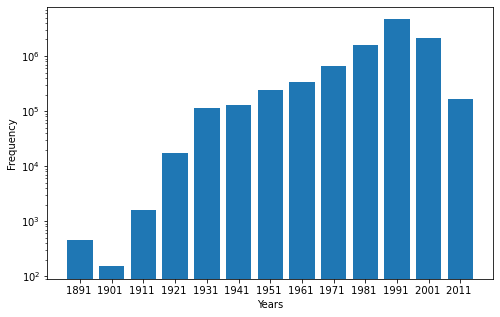

In [ ]:
x = range(len(a))
y = a.values
plt.figure(figsize=(8,5))
plt.bar(x,y,align='center') # A bar chart
plt.xticks(ticks = range(len(a)), labels= yy)
plt.yscale('log')
plt.xlabel('Years')
plt.ylabel('Frequency')
plt.show()

#### genre

In [ ]:
genres= ['Anim.', 'Children', 'Comedy', 'Crime', 'Docu.', 'Drama',
       'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mys.',
       'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', 'None']

In [ ]:
b = userMovieData[genres].sum()

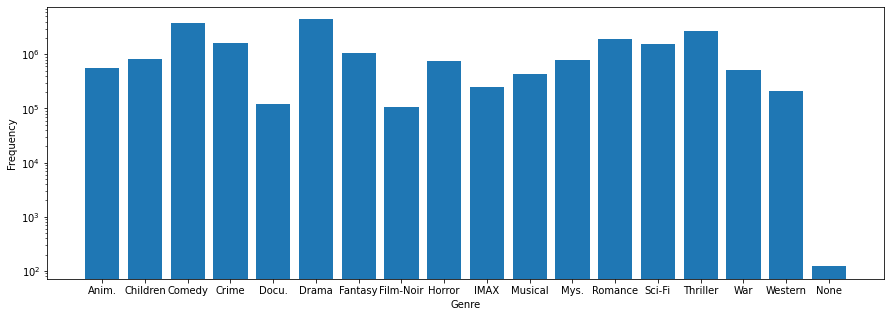

In [ ]:
x = range(len(b))
y = b.values
plt.figure(figsize=(15,5))
plt.bar(x,y,align='center') # A bar chart
plt.xticks(ticks = range(len(b)), labels= genres)
plt.yscale('log')
plt.xlabel('Genre')
plt.ylabel('Frequency')
plt.show()

Label distrib

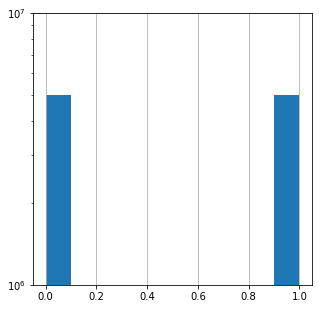

In [ ]:
plt.figure(figsize=(5,5))
plt.ylim((1e6, 10e6))
(userMovieData['rating'] > 3.9).astype('uint8').hist(log=True)


### Adjency matrix

In [ ]:
# User Id, Movie Id
print(userMovieData['movieId'].max())
print(userMovieData['userId'].max())

26743
69139


In [ ]:
# Dimensions
graph.adjency.shape

(69140, 26744)

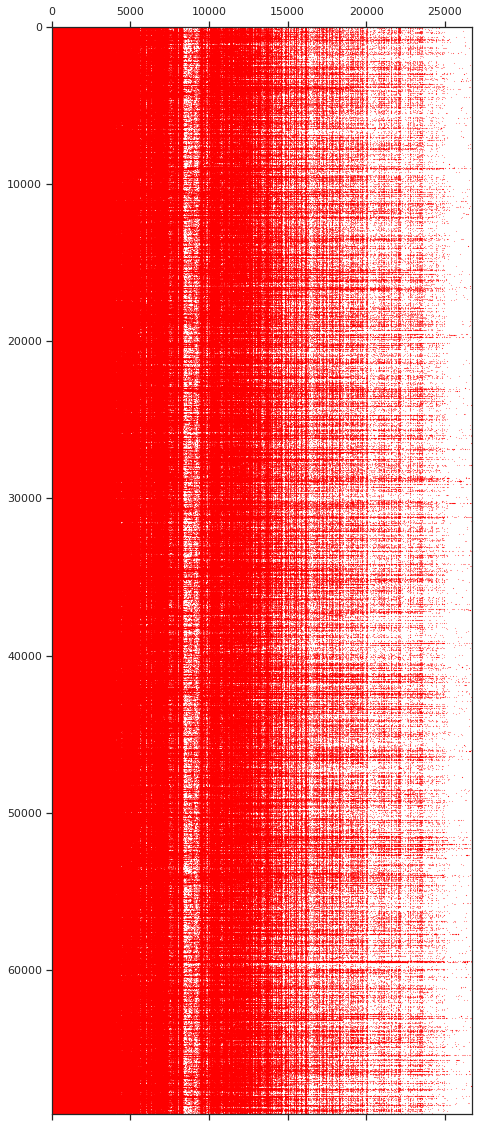

In [ ]:
# All matrix
plt.figure(figsize=(10,20))
plt.spy(graph.adjency, markersize=0.1, color='red')
plt.show()

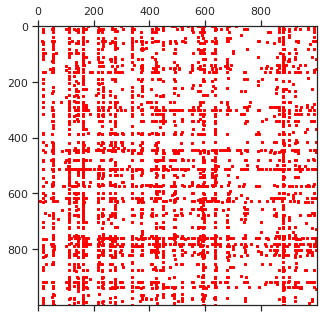

In [ ]:
## Zoom axes nb not significant
x_min= 10000
y_min= 10000
plt.figure(figsize=(5,10))
plt.spy(graph.colFormat[x_min:x_min+1000, y_min:y_min+1000], markersize=2, color='red')
plt.show()

#### Note : comparison with adjency matrix (20M)

#### Comparison with degree dist

In [ ]:
def custom_log(arr):
  out = np.zeros_like(arr, dtype='float32')
  out[np.where(arr!=0)]= np.log(arr[np.where(arr!=0)])
  out[np.where(arr==0)]= -1
  return out

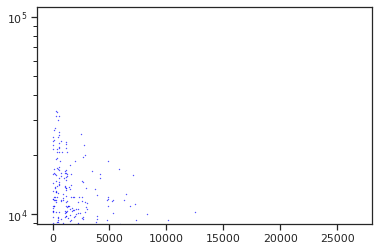

In [ ]:
# Movie Degree scaled (from adjency)
n = graph.colFormat.shape[1]
movieDeg = np.array([graph.colFormat[:,j].nnz for j in range(1,n)])

fig, ax = plt.subplots(1,1)
ax.scatter(range(1,n), movieDeg, color='blue',s=0.1)
ax.set_yscale('log')
plt.show()

##### Directement depuis la DB (ne vient pas de la mat adj)

In [ ]:
# Directly from dB
movieDegDB = NodeFeatures.movie_degree(userMovieData.groupby('movieId'))

In [ ]:
n = movieDegDB.index.max()

In [ ]:
movieDegArr = np.zeros((n,))
movieDegArr[movieDegDB.index - 1] = movieDegDB

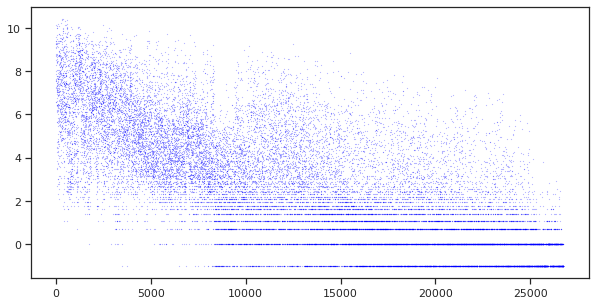

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(range(n), custom_log(movieDegArr), color='blue',s=0.01)
plt.axis()
plt.show()

##### Comparison with 20M

### Feature Analysis

#### Pair Plot

In [ ]:
clf = LogRegClf(userMovieData, graph.adjency, likeThr=3.4)
X, _, _ = clf._get_feature_matrix(graph.edges)

In [ ]:
y = clf._get_labels(graph.edges)

In [ ]:
X_ = X.iloc[::1000, 2:10]
X_.columns = ['usr_mn', 'usr_std', 'usr_deg', 'usr_tag', 'mv_mn', 'mv_std', 'mv_deg', 'mv_tag']

In [ ]:
y_ = y.iloc[::1000]

In [ ]:
X_['label'] = y_

In [ ]:
X_.head(5)

,usr_mn,usr_std,usr_deg,usr_tag,mv_mn,mv_std,mv_deg,mv_tag,label
0,3.742857,0.381190,175,0,3.210879,0.946202,23,11049,1
1000,3.945437,1.174928,504,0,4.308281,0.822413,82,25094,1
2000,3.611570,1.093723,121,0,3.989017,0.721846,10,956,1
3000,3.332016,1.063425,506,0,3.308369,0.900560,3,3525,0
4000,4.248718,0.794814,195,0,4.044008,0.956566,75,26802,1


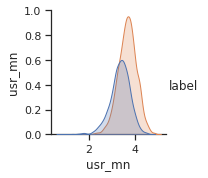

In [ ]:
sns.set(rc={'figure.figsize':(15,15)})
sns.set_theme(style="ticks")

x_vars = ["usr_mn"]
y_vars = ["usr_tag"]

g = sns.PairGrid(X_, hue='label', x_vars=x_vars, y_vars=y_vars)
g.map_diag(sns.kdeplot, color=".3", fill=True)
g.map_offdiag(sns.scatterplot)
g.add_legend()

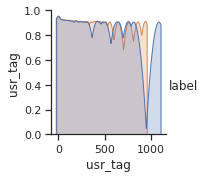

In [ ]:
sns.set_theme(style="ticks")
x_vars = ["usr_tag"]
y_vars = ["usr_tag"]
g = sns.PairGrid(X_, hue='label', x_vars=x_vars, y_vars=y_vars)
g.map_diag(sns.kdeplot, color=".3", fill= True)
ax = g.diag_axes[0]
ax.set_yscale('log')
g.map_offdiag(sns.scatterplot)
g.add_legend()

In [ ]:
ax = g.axes[2,0]
ax.set_yscale('log')

In [ ]:
g

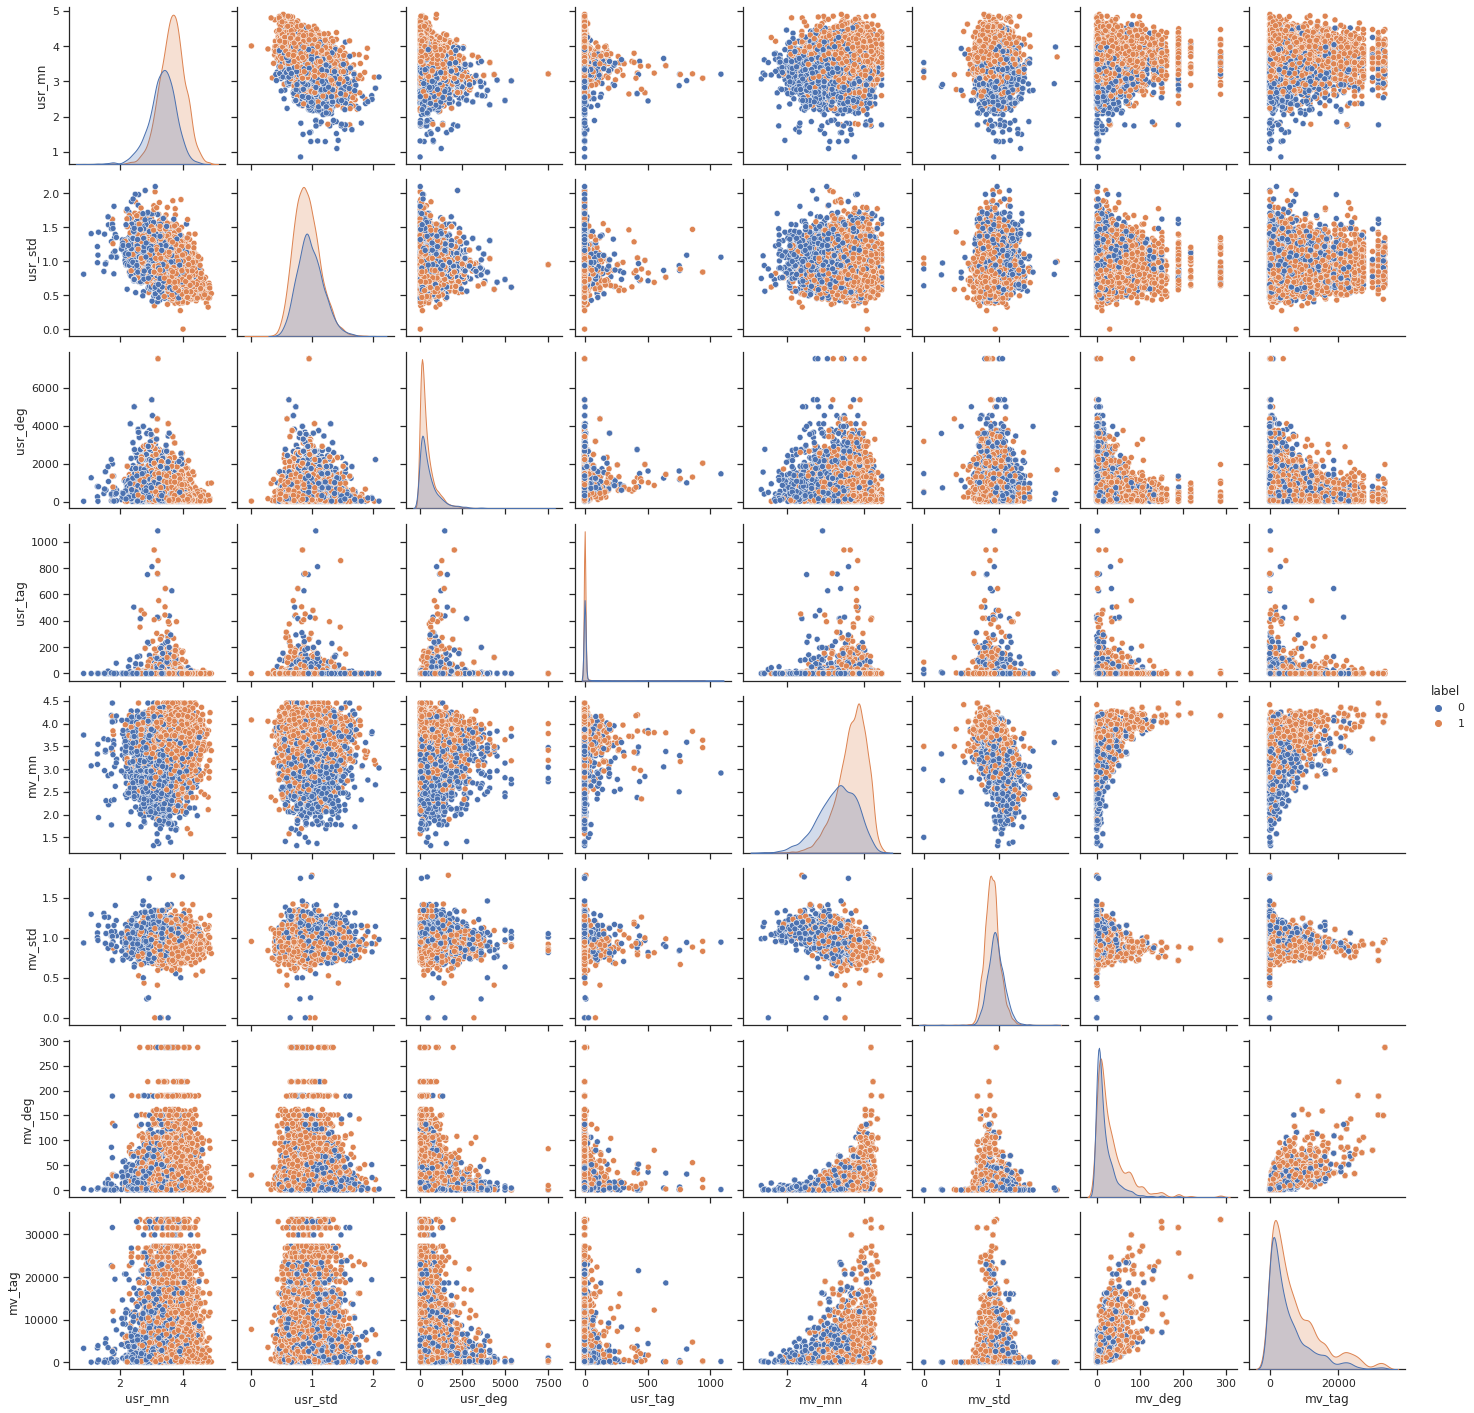

In [ ]:
sns.set_theme(style="ticks")
sns.pairplot(X_, hue='label')

### Feature Selection 

#### Chi square test

In [ ]:
clf = LogRegClf(userMovieData, graph.adjency, likeThr=3.4)
X, _, _ = clf._get_feature_matrix(graph.edges)
y = clf._get_labels(graph.edges)

In [ ]:
# subsampling
X_ = X.iloc[:1000000, 2:]
y_ = y[:1000000]

In [ ]:
# to sparse (uses a lot of memory)
X_sparse = clf._get_sparse(X_, dType='csr')

In [ ]:
chi2Stat, pVal = chi2(X_sparse, y_)

In [ ]:
pVal> 0.05

array([False, False, False, False, False, False,  True, False,  True,
       False, False, False, False, False,  True, False, False,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False])

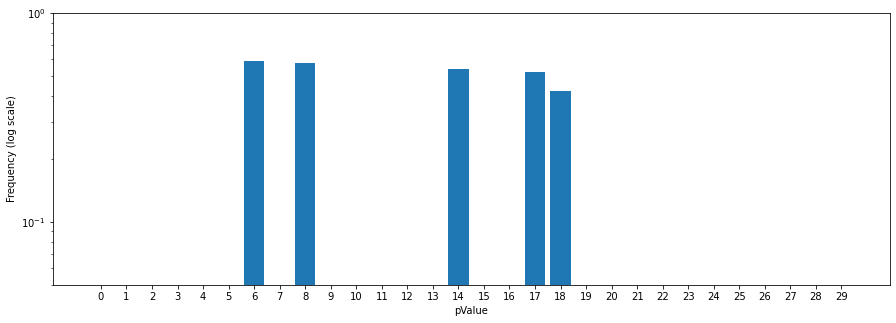

In [ ]:
b = pVal
x = range(len(b))
y = b
plt.figure(figsize=(15,5))
plt.bar(x,y,align='center') # A bar chart
plt.xticks(ticks = range(len(b)))
plt.yscale('log')
plt.ylim(bottom= .05, top = 1)
plt.xlabel('pValue')
plt.ylabel('Frequency (log scale)')
plt.show()

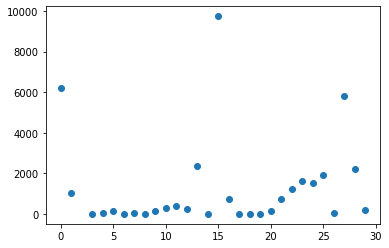

In [ ]:
plt.scatter(range(len(chi2Stat)), chi2Stat)

In [ ]:
X.iloc[:,2:10].columns[pVal > 0.]

Index(['xu0', 'xu1', 'xm0', 'xm1'], dtype='object')

#### Feature importance (using GB clf)

In [ ]:
def set_featFncts(self):
    # -- setting feature functions
    self.featFncts = {'user': [NodeFeatures.user_mean, 
                               NodeFeatures.user_std,
                               NodeFeatures.user_degree,
                               NodeFeatures.user_tag],
                      'movie': [NodeFeatures.movie_mean,
                                NodeFeatures.movie_std,
                                NodeFeatures.movie_tag,
                                NodeFeatures.movie_degree,
                                NodeFeatures.movie_genre,
                                NodeFeatures.movie_year]}
    pass

In [ ]:
GradientBoostingClf.set_featFncts = set_featFncts

In [ ]:
min_samples_split = 2
max_features = 20
x = 0.0284
y = 47
z = 3
k = 23
l = 0.06884

In [ ]:
grd = GradientBoostingClf(userMovieData, graph.adjency,
                           likeThr = likeThr, 
                            lr= l, 
                            subsample = x,
                            min_samples_leaf= k, 
                            min_samples_split= min_samples_split,
                            max_depth= z,
                            max_features= max_features,
                            n_estimators= y,
                            RANDOM_SEED= RANDOM_SEED_CLF)


In [ ]:
grd.fit(graph.edges[::2])

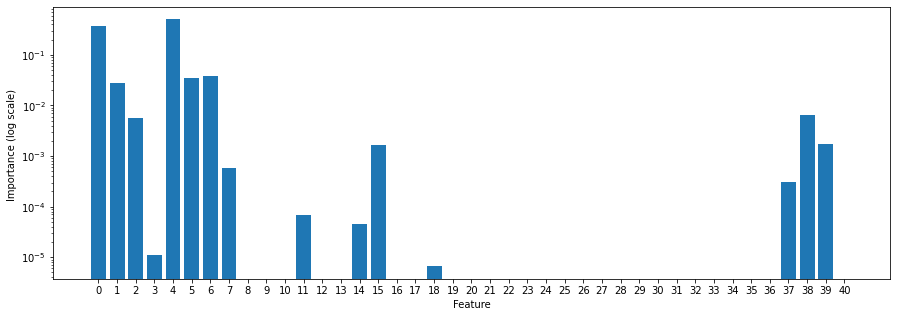

In [ ]:
b = grd.clf.feature_importances_
x = range(len(b))
y = b
plt.figure(figsize=(15,5))
plt.bar(x,y,align='center') # A bar chart
plt.xticks(ticks = range(len(b)))
plt.yscale('log')
plt.xlabel('Feature')
plt.ylabel('Importance (log scale)')
plt.show()

In [ ]:
nz = np.array([0, 1, 2, 3, 4, 5, 6, 7, 11, 14, 15, 18, 37, 38, 39]) + 2
grd.xTrain.columns[nz]

Index(['xu0', 'xu1', 'xu2', 'xu3', 'xm0', 'xm1', 'xm2', 'xm3', 'xm7', 'xm10',
       'xm11', 'xm14', 'xm33', 'xm34', 'xm35'],
      dtype='object')

### Dimension Reduction (PCA)

Note: PCA doesn't work on sparse matrices, we prefer to use a truncated SVD.

In [ ]:
clf = LogRegClf(userMovieData, graph.adjency, likeThr=3.4)
X, _, _ = clf._get_feature_matrix(graph.edges)
y = clf._get_labels(graph.edges)

In [ ]:
# subsampling
X_ = X.iloc[::100]
y_ = y[::100]

In [ ]:
# to sparse (uses a lot of memory)
X_sparse_ = clf._get_sparse(X_, dType='csr')

In [ ]:
svd = TruncatedSVD(n_components=5, n_iter= 10, algorithm= 'randomized', random_state=42)
svd.fit(X_sparse_)

TruncatedSVD(algorithm='randomized', n_components=5, n_iter=10, random_state=42,
             tol=0.0)

In [ ]:
svd.explained_variance_ratio_

array([4.64699681e-01, 4.69189175e-01, 6.55980112e-02, 5.10701340e-04,
       1.80458279e-06])

## Models comparison

### Classifiers

In [ ]:
'''
Trivial Recommender System
'''

#%% Modules
# standard
import numpy as np

#%% Trivial Recommendation System
class TrivialClf(_Clf):
    def __init__(self, df, adj, likeThr):
        self.set_featFncts()
        super().__init__(df,adj, likeThr, RANDOM_SEED= None)
        pass

    def set_featFncts(self):
        # -- setting feature functions
        self.featFncts = {'user': [NodeFeatures.user_mean],
              'movie': [NodeFeatures.movie_mean]
              }

    def fit(self, edges):
        '''Nothing parameter to fit for this clf
        '''
        self.xTrain, self.X_u, self.X_m = self._get_feature_matrix(edges)
        pass

    def _predict_known(self, xTestKnown, dType):
        return likeThr < xTestKnown['xm0']


In [ ]:
'''
Logistic Regression
'''
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

class LogRegClf(_Clf):
    def __init__(self, df, adj, likeThr=3.4, C0= 1e0, balanced= True, RANDOM_SEED=None):
        super().__init__(df,adj, likeThr, RANDOM_SEED)
        self.set_featFncts()
        self.C0 = C0
        self.class_weight = 'balanced' if balanced else None
        self.clf = LogisticRegression(C = self.C0, class_weight=self.class_weight,
                                      solver= 'saga', random_state= self.RANDOM_SEED)
        pass

    def set_featFncts(self):
        # -- setting feature functions
        self.featFncts = {'user': [NodeFeatures.user_mean],
              'movie': [NodeFeatures.movie_mean]
              }


In [ ]:
class GradientBoostingClf(_Clf):
    def __init__(self, df, adj, likeThr=3.4, max_depth= None, max_features= None,
                 lr= 0.1, min_samples_split= 2, min_samples_leaf= 1, n_estimators=100,
                 subsample= 0.01, RANDOM_SEED=None):
        super().__init__(df,adj, likeThr, RANDOM_SEED)
        self.set_featFncts()

        # -- setting sklearn clf
        self.lr = lr
        self.subsample = subsample
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.clf = GradientBoostingClassifier(n_estimators=self.n_estimators, 
                                              learning_rate=self.lr,
                                              subsample= self.subsample,
                                              max_depth=self.max_depth,
                                              max_features = self.max_features,
                                              min_samples_split= self.min_samples_split,
                                              min_samples_leaf= self.min_samples_leaf,
                                              random_state= self.RANDOM_SEED)
        pass

    def set_featFncts(self):
        # -- setting feature functions
        self.featFncts = {'user': [NodeFeatures.user_mean],
              'movie': [NodeFeatures.movie_mean]
              }
        pass

In [ ]:
class TreeClf(_Clf):
    def __init__(self, df, adj, likeThr=3.4, max_depth= None, min_samples_split= 2, min_samples_leaf= 1, 
                 RANDOM_SEED=None):
        super().__init__(df,adj, likeThr, RANDOM_SEED)
        self.set_featFncts()

        # -- setting sklearn clf
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.clf = DecisionTreeClassifier(max_depth=self.max_depth,
                                              min_samples_split= self.min_samples_split,
                                              min_samples_leaf= self.min_samples_leaf,
                                              random_state= self.RANDOM_SEED)
        pass

    def set_featFncts(self):
        # -- setting feature functions
        self.featFncts = {'user': [NodeFeatures.user_mean],
              'movie': [NodeFeatures.movie_mean]
              }
        pass

### Features

#### mean, std for user and movie

In [ ]:
def set_featFncts(self):
    # -- setting feature functions
    self.featFncts = {'user': [NodeFeatures.user_mean, 
                               NodeFeatures.user_std],
                      'movie': [NodeFeatures.movie_mean,
                                NodeFeatures.movie_std]}
    pass

In [ ]:
LogRegClf.set_featFncts = set_featFncts
GradientBoostingClf.set_featFncts = set_featFncts
TreeClf.set_featFncts = set_featFncts

In [ ]:
## Shared parameters
likeThr = 3.4
RANDOM_SEED_CLF = 42
RANDOM_SEED_CV = 21

##### Logistic regression

In [ ]:
clf = LogRegClf(userMovieData, graph.adjency, C0=1e9, RANDOM_SEED=RANDOM_SEED_CLF)

In [ ]:
cross_val_score(clf, cv=5, RANDOM_SEED=RANDOM_SEED_CV)

##### tree

In [ ]:
# Bounded region of parameter space
pBounds = {'x': (5, 30), 'y': (10, 30), 'z': (3,7)}

In [ ]:
to_optimize = lambda x, y, z: np.mean(cross_val_score(TreeClf(userMovieData, 
                                                        graph.adjency,
                                                        likeThr = likeThr,
                                                        min_samples_leaf= x,
                                                        min_samples_split= y,
                                                        max_depth= z,
                                                        RANDOM_SEED = RANDOM_SEED_CLF), RANDOM_SEED= RANDOM_SEED_CV))

def to_optimize_discrete(x, y, z):
    x,y,z = int(x), int(y), int(z)
    return to_optimize(x,y,z)

In [ ]:
OPTIMIZER_SEED = 1
optimizer = BayesianOptimization(
    f= to_optimize_discrete,
    pbounds=pBounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=OPTIMIZER_SEED,
)

In [ ]:
optimizer.maximize(
    init_points=2,
    n_iter=10,
)

|   iter    |  target   |     x     |     y     |     z     |
-------------------------------------------------------------
|  1        |  0.6806   |  15.43    |  24.41    |  3.0      |
|  2        |  0.6806   |  12.56    |  12.94    |  3.369    |
|  3        |  0.6988   |  29.78    |  29.99    |  5.877    |
|  4        |  0.6806   |  29.86    |  10.07    |  3.411    |
|  5        |  0.6952   |  5.482    |  28.91    |  6.989    |
|  6        |  0.6952   |  29.86    |  25.4     |  6.988    |
|  7        |  0.6952   |  24.0     |  29.98    |  6.991    |
|  8        |  0.6952   |  5.549    |  10.05    |  6.935    |
|  9        |  0.6952   |  29.55    |  29.35    |  6.518    |
|  10       |  0.6952   |  30.0     |  29.92    |  6.923    |
|  11       |  0.6952   |  28.82    |  29.48    |  6.875    |
|  12       |  0.6952   |  5.238    |  29.94    |  6.907    |


##### Gradient Boosting

Parameters tuning - Bayesian

In [ ]:
# Bounded region of parameter space
pBounds = {'x': (0.01, 0.1), 'y': (30, 50), 'z': (3,10), 'k':(5,50), 'l':(0.001, 0.1)}

In [ ]:
min_samples_split = 2
max_features = 4
to_optimize = lambda x, y, z, k, l : np.mean(cross_val_score(GradientBoostingClf(userMovieData, graph.adjency,
                                                      likeThr = likeThr, 
                                                      lr= l, 
                                                      subsample = x,
                                                      min_samples_leaf= k, 
                                                      min_samples_split= min_samples_split,
                                                      max_depth= z,
                                                      max_features= max_features,
                                                      n_estimators= y,
                                                      RANDOM_SEED= RANDOM_SEED_CLF), RANDOM_SEED= RANDOM_SEED_CV))

def to_optimize_discrete(x, y, z, k, l):
    y,z,k = int(y), int(z), int(k)
    return to_optimize(x,y,z,k, l)

In [ ]:
OPTIMIZER_SEED = 1
optimizer = BayesianOptimization(
    f= to_optimize_discrete,
    pbounds=pBounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=OPTIMIZER_SEED,
)

In [ ]:
optimizer.maximize(
    init_points=2,
    n_iter=10,
)

|   iter    |  target   |     k     |     l     |     x     |     y     |     z     |
-------------------------------------------------------------------------------------
|  1        |  0.7002   |  23.77    |  0.07231  |  0.01001  |  36.05    |  4.027    |
|  2        |  0.6668   |  9.155    |  0.01944  |  0.0411   |  37.94    |  6.772    |
|  3        |  0.3793   |  50.0     |  0.001    |  0.1      |  50.0     |  10.0     |
|  4        |  0.7019   |  50.0     |  0.1      |  0.01     |  30.0     |  10.0     |
|  5        |  0.7009   |  5.0      |  0.1      |  0.1      |  30.0     |  3.0      |
|  6        |  0.3793   |  22.32    |  0.001    |  0.1      |  30.0     |  10.0     |


#### 2nd set : mix

In [ ]:
def set_featFncts(self):
    # -- setting feature functions
    self.featFncts = {'user': [NodeFeatures.user_mean, 
                               NodeFeatures.user_std,
                               NodeFeatures.user_degree,
                               NodeFeatures.user_tag],
                      'movie': [NodeFeatures.movie_mean,
                                NodeFeatures.movie_std,
                                NodeFeatures.movie_tag,
                                NodeFeatures.movie_degree,
                                NodeFeatures.movie_genre,
                                NodeFeatures.movie_year]}
    pass

In [ ]:
LogRegClf.set_featFncts = set_featFncts
GradientBoostingClf.set_featFncts = set_featFncts
TreeClf.set_featFncts = set_featFncts

##### Model Selection

In [ ]:
## Shared parameters
likeThr = 3.4
RANDOM_SEED_CLF = 42
RANDOM_SEED_CV = 21

###### Trivial Clf

In [ ]:
# Trivial Clf
trivClf = TrivialClf(userMovieData, graph.adjency, likeThr = likeThr)

In [ ]:
trivScores = cross_val_score(trivClf, RANDOM_SEED=RANDOM_SEED_CV)

In [ ]:
y = trivClf._get_labels(graph.edges)

In [ ]:
sum(y)/len(y)

0.6101507

In [ ]:
trivScores

[0.6645613869164647,
 0.6644920458288781,
 0.6652823313749641,
 0.6653393459469401,
 0.6651233071743026]

###### Logistic Regression

In [ ]:
!pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp36-none-any.whl size=11685 sha256=967b274f22100cbb74c486e5a5782fed064f4f073fcc3faca010088d3a1d022b
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization


In [ ]:
from bayes_opt import BayesianOptimization

In [ ]:
# Bounded region of parameter space
balanced = True
pBounds = {'x':(1e-3,1e3)}

In [ ]:
to_optimize = lambda x: np.mean(cross_val_score(LogRegClf(userMovieData, graph.adjency, 
                                                                likeThr = likeThr,
                                                                C0=x,
                                                                balanced = balanced,
                                                                RANDOM_SEED= RANDOM_SEED_CLF),
                                                       RANDOM_SEED= RANDOM_SEED_CV))


In [ ]:
OPTIMIZER_SEED = 1
optimizer = BayesianOptimization(
    f= to_optimize,
    pbounds=pBounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=OPTIMIZER_SEED,
)

In [ ]:
optimizer.maximize(
    init_points=2,
    n_iter=3,
)

|   iter    |  target   |     x     |
-------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

|  1        |  0.757    |  0.1154   |


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

|  2        |  0.757    |  302.3    |


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


###### Tree

In [ ]:
!pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp36-none-any.whl size=11685 sha256=4c25406429c0c73211f624c7373542df5a8f7d7b1074b76b8c5f20fa65a7f567
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization


In [ ]:
from bayes_opt import BayesianOptimization

In [ ]:
# Bounded region of parameter space
pBounds = {'x': (5, 30), 'y': (10, 30), 'z': (3,7)}

In [ ]:
to_optimize = lambda x, y, z: np.mean(cross_val_score(TreeClf(userMovieData, 
                                                        graph.adjency,
                                                        likeThr = likeThr,
                                                        min_samples_leaf= x,
                                                        min_samples_split= y,
                                                        max_depth= z,
                                                        RANDOM_SEED = RANDOM_SEED_CLF), RANDOM_SEED= RANDOM_SEED_CV))

def to_optimize_discrete(x, y, z):
    x,y,z = int(x), int(y), int(z)
    return to_optimize(x,y,z)

In [ ]:
OPTIMIZER_SEED = 1
optimizer = BayesianOptimization(
    f= to_optimize_discrete,
    pbounds=pBounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=OPTIMIZER_SEED,
)

In [ ]:
optimizer.maximize(
    init_points=2,
    n_iter=30,
)

|   iter    |  target   |     x     |     y     |     z     |
-------------------------------------------------------------
|  1        |  0.6806   |  15.43    |  24.41    |  3.0      |
|  2        |  0.6806   |  12.56    |  12.94    |  3.369    |
|  3        |  0.6988   |  29.78    |  29.99    |  5.877    |
|  4        |  0.6806   |  29.86    |  10.07    |  3.411    |
|  5        |  0.695    |  5.482    |  28.91    |  6.989    |
|  6        |  0.695    |  29.86    |  25.4     |  6.988    |
|  7        |  0.695    |  24.0     |  29.98    |  6.991    |
|  8        |  0.695    |  5.549    |  10.05    |  6.935    |
|  9        |  0.695    |  29.55    |  29.35    |  6.518    |
|  10       |  0.695    |  30.0     |  29.92    |  6.923    |
|  11       |  0.695    |  28.82    |  29.48    |  6.875    |
|  12       |  0.695    |  5.238    |  29.94    |  6.907    |
|  13       |  0.695    |  29.43    |  29.8     |  6.475    |


KeyboardInterrupt: ignored

###### Gradient Boosting

Parameters tuning - Bayesian

In [ ]:
!pip install bayesian-optimization

In [ ]:
from bayes_opt import BayesianOptimization

In [ ]:
# Bounded region of parameter space
pBounds = {'x': (0.01, 0.1), 'y': (30, 50), 'z': (3,10), 'k':(5,50), 'l':(0.001, 0.1)}

In [ ]:
min_samples_split = 2
max_features = 20
to_optimize = lambda x, y, z, k, l : np.mean(cross_val_score(GradientBoostingClf(userMovieData, graph.adjency,
                                                      likeThr = likeThr, 
                                                      lr= l, 
                                                      subsample = x,
                                                      min_samples_leaf= k, 
                                                      min_samples_split= min_samples_split,
                                                      max_depth= z,
                                                      max_features= max_features,
                                                      n_estimators= y,
                                                      RANDOM_SEED= RANDOM_SEED_CLF), RANDOM_SEED= RANDOM_SEED_CV))

def to_optimize_discrete(x, y, z, k, l):
    y,z,k = int(y), int(z), int(k)
    return to_optimize(x,y,z,k, l)

In [ ]:
OPTIMIZER_SEED = 1
optimizer = BayesianOptimization(
    f= to_optimize_discrete,
    pbounds=pBounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=OPTIMIZER_SEED,
)

In [ ]:
optimizer.maximize(
    init_points=2,
    n_iter=30,
)

|   iter    |  target   |     k     |     l     |     x     |     y     |     z     |
-------------------------------------------------------------------------------------
|  1        |  0.7012   |  23.77    |  0.07231  |  0.01001  |  36.05    |  4.027    |


KeyboardInterrupt: ignored

Best params: 20.0 0.01 15.0 5.0

Feature Importance

Try out of the blue

In [ ]:
# Gradient Boosting
lr = .1
subsample= 0.01 # grosse valeur sature la mémoire
n_estimators = 10
max_depth = 3
max_features = 10
min_samples_split = 2
min_samples_leaf = 20

# -- Def
gradClf = GradientBoostingClf(userMovieData, graph.adjency,
                              likeThr = likeThr, 
                              lr= 1e-1, 
                              subsample = 0.01,
                              min_samples_leaf= min_samples_leaf, 
                              min_samples_split= min_samples_split,
                              max_depth= max_depth,
                              max_features= max_features,
                              n_estimators= n_estimators,
                              RANDOM_SEED= RANDOM_SEED)

In [ ]:
gradScores = cross_val_score(gradClf)

prop of classes chosen at random 0.0004605
prop of classes chosen at random 0.0004725
prop of classes chosen at random 0.0004685
prop of classes chosen at random 0.000482
prop of classes chosen at random 0.000483


In [ ]:
gradScores

[0.7923974627471774,
 0.7929951630195092,
 0.7892921382082094,
 0.7904370667872732,
 0.7931609677665851]

#### 3rd set : genre

In [ ]:
def set_featFncts(self):
    # -- setting feature functions
    self.featFncts = {'user': [NodeFeatures.user_mean, 
                               NodeFeatures.user_std,
                               NodeFeatures.user_genre],
                      'movie': [NodeFeatures.movie_mean,
                                NodeFeatures.movie_std,
                                NodeFeatures.movie_genre]}
    pass

In [ ]:
LogRegClf.set_featFncts = set_featFncts
GradientBoostingClf.set_featFncts = set_featFncts
TreeClf.set_featFncts = set_featFncts

In [ ]:
## Shared parameters
likeThr = 3.4
RANDOM_SEED_CLF = 42
RANDOM_SEED_CV = 21

##### tree

In [ ]:
!pip install bayesian-optimization

In [ ]:
from bayes_opt import BayesianOptimization

In [ ]:
# Bounded region of parameter space
pBounds = {'x': (5, 30), 'y': (10, 30), 'z': (3,7)}

In [ ]:
to_optimize = lambda x, y, z: np.mean(cross_val_score(TreeClf(userMovieData, 
                                                        graph.adjency,
                                                        likeThr = likeThr,
                                                        min_samples_leaf= x,
                                                        min_samples_split= y,
                                                        max_depth= z,
                                                        RANDOM_SEED = RANDOM_SEED_CLF), RANDOM_SEED= RANDOM_SEED_CV))

def to_optimize_discrete(x, y, z):
    x,y,z = int(x), int(y), int(z)
    return to_optimize(x,y,z)

In [ ]:
OPTIMIZER_SEED = 1
optimizer = BayesianOptimization(
    f= to_optimize_discrete,
    pbounds=pBounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=OPTIMIZER_SEED,
)

In [ ]:
optimizer.maximize(
    init_points=2,
    n_iter=10,
)

|   iter    |  target   |     x     |     y     |     z     |
-------------------------------------------------------------
|  1        |  0.6806   |  15.43    |  24.41    |  3.0      |
|  2        |  0.6806   |  12.56    |  12.94    |  3.369    |
|  3        |  0.6988   |  29.78    |  29.99    |  5.877    |
|  4        |  0.6806   |  29.86    |  10.07    |  3.411    |
|  5        |  0.6952   |  5.482    |  28.91    |  6.989    |
|  6        |  0.6952   |  29.86    |  25.4     |  6.988    |
|  7        |  0.6952   |  24.0     |  29.98    |  6.991    |


##### Gradient Boosting

Parameters tuning - Bayesian

In [ ]:
!pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp36-none-any.whl size=11685 sha256=61615798de384a6d33e4f6d9ff7a5a9fb41b1fd7677e3f4498eac89bb890bd8d
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization


In [ ]:
from bayes_opt import BayesianOptimization

In [ ]:
# Bounded region of parameter space
pBounds = {'x': (0.01, 0.1), 'y': (30, 50), 'z': (3,10), 'k':(5,50), 'l':(0.001, 0.1)}

In [ ]:
min_samples_split = 2
max_features = 20
to_optimize = lambda x, y, z, k, l : np.mean(cross_val_score(GradientBoostingClf(userMovieData, graph.adjency,
                                                      likeThr = likeThr, 
                                                      lr= l, 
                                                      subsample = x,
                                                      min_samples_leaf= k, 
                                                      min_samples_split= min_samples_split,
                                                      max_depth= z,
                                                      max_features= max_features,
                                                      n_estimators= y,
                                                      RANDOM_SEED= RANDOM_SEED_CLF), RANDOM_SEED= RANDOM_SEED_CV))

def to_optimize_discrete(x, y, z, k, l):
    y,z,k = int(y), int(z), int(k)
    return to_optimize(x,y,z,k, l)

In [ ]:
OPTIMIZER_SEED = 1
optimizer = BayesianOptimization(
    f= to_optimize_discrete,
    pbounds=pBounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=OPTIMIZER_SEED,
)

In [ ]:
optimizer.maximize(
    init_points=2,
    n_iter=10,
)

|   iter    |  target   |     k     |     l     |     x     |     y     |     z     |
-------------------------------------------------------------------------------------
|  1        |  0.6618   |  9.155    |  0.01944  |  0.0411   |  37.94    |  6.772    |
|  2        |  0.6998   |  23.86    |  0.06884  |  0.0284   |  47.56    |  3.192    |
|  3        |  0.6863   |  35.17    |  0.04231  |  0.06028  |  32.81    |  4.387    |
|  4        |  0.7026   |  49.13    |  0.04106  |  0.05624  |  49.91    |  9.369    |
|  5        |  0.696    |  49.15    |  0.04914  |  0.05315  |  49.22    |  3.125    |
|  6        |  0.6956   |  28.28    |  0.02668  |  0.08379  |  49.93    |  9.899    |
|  7        |  0.701    |  49.82    |  0.05682  |  0.04806  |  31.08    |  9.371    |
|  8        |  0.3793   |  5.53     |  0.003394 |  0.09346  |  49.81    |  3.349    |


KeyboardInterrupt: ignored

#### 4th set : year

In [ ]:
def set_featFncts(self):
    # -- setting feature functions
    self.featFncts = {'user': [NodeFeatures.user_mean, 
                               NodeFeatures.user_std,
                               NodeFeatures.user_year],
                      'movie': [NodeFeatures.movie_mean,
                                NodeFeatures.movie_std,
                                NodeFeatures.movie_year]}
    pass

In [ ]:
LogRegClf.set_featFncts = set_featFncts
GradientBoostingClf.set_featFncts = set_featFncts
TreeClf.set_featFncts = set_featFncts

##### Model Selection

In [ ]:
## Shared parameters
likeThr = 3.4
RANDOM_SEED_CLF = 42
RANDOM_SEED_CV = 21

###### Tree

In [ ]:
!pip install bayesian-optimization

In [ ]:
from bayes_opt import BayesianOptimization

In [ ]:
# Bounded region of parameter space
pBounds = {'x': (5, 30), 'y': (10, 30), 'z': (3,7)}

In [ ]:
to_optimize = lambda x, y, z: np.mean(cross_val_score(TreeClf(userMovieData, 
                                                        graph.adjency,
                                                        likeThr = likeThr,
                                                        min_samples_leaf= x,
                                                        min_samples_split= y,
                                                        max_depth= z,
                                                        RANDOM_SEED = RANDOM_SEED_CLF), RANDOM_SEED= RANDOM_SEED_CV))

def to_optimize_discrete(x, y, z):
    x,y,z = int(x), int(y), int(z)
    return to_optimize(x,y,z)

In [ ]:
OPTIMIZER_SEED = 1
optimizer = BayesianOptimization(
    f= to_optimize_discrete,
    pbounds=pBounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=OPTIMIZER_SEED,
)

In [ ]:
optimizer.maximize(
    init_points=2,
    n_iter=10,
)

|   iter    |  target   |     x     |     y     |     z     |
-------------------------------------------------------------
|  1        |  0.6806   |  15.43    |  24.41    |  3.0      |
|  2        |  0.6806   |  12.56    |  12.94    |  3.369    |
|  3        |  0.6988   |  29.78    |  29.99    |  5.877    |
|  4        |  0.6806   |  29.86    |  10.07    |  3.411    |
|  5        |  0.6975   |  5.482    |  28.91    |  6.989    |
|  6        |  0.6975   |  29.86    |  25.4     |  6.988    |
|  7        |  0.6975   |  24.0     |  29.98    |  6.991    |
|  8        |  0.6975   |  5.549    |  10.05    |  6.935    |
|  9        |  0.6975   |  27.01    |  29.98    |  6.971    |
|  10       |  0.6975   |  30.0     |  29.92    |  6.923    |


KeyboardInterrupt: ignored

###### Gradient Boosting

Parameters tuning - Bayesian

In [ ]:
# Bounded region of parameter space
pBounds = {'x': (0.01, 0.1), 'y': (30, 50), 'z': (3,10), 'k':(5,50), 'l':(0.001, 0.1)}

In [ ]:
min_samples_split = 2
max_features = 20
to_optimize = lambda x, y, z, k, l : np.mean(cross_val_score(GradientBoostingClf(userMovieData, graph.adjency,
                                                      likeThr = likeThr, 
                                                      lr= l, 
                                                      subsample = x,
                                                      min_samples_leaf= k, 
                                                      min_samples_split= min_samples_split,
                                                      max_depth= z,
                                                      max_features= max_features,
                                                      n_estimators= y,
                                                      RANDOM_SEED= RANDOM_SEED_CLF), RANDOM_SEED= RANDOM_SEED_CV))

def to_optimize_discrete(x, y, z, k, l):
    y,z,k = int(y), int(z), int(k)
    return to_optimize(x,y,z,k, l)

In [ ]:
OPTIMIZER_SEED = 1
optimizer = BayesianOptimization(
    f= to_optimize_discrete,
    pbounds=pBounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=OPTIMIZER_SEED,
)

In [ ]:
optimizer.maximize(
    init_points=2,
    n_iter=10,
)